# Module 6: CFA
# Use Case: Investment using Symbollic Artificial Intelligence
# =============================================================

After Dan Philps, Tim Law et al 2021. https://jfds.pm-research.com/content/early/2021/09/22/jfds.2021.1.077

https://github.com/danphilps/Investment-SAI


Get key packages, download data and get in good shape.

In [215]:
# package for working with tabular data
import pandas as pd 
import numpy as np

# package for navigating the operating system
import os

If this is running in Google Colab.... we extract the GitHub loc where the data resides....

In [216]:
!git clone https://github.com/danphilps/Investment-SAI

Cloning into 'Investment-SAI'...
remote: Enumerating objects: 100, done.
remote: Counting objects: 100% (100/100), done.
remote: Compressing objects: 100% (93/93), done.
remote: Total 100 (delta 37), reused 19 (delta 4), pack-reused 0
Receiving objects: 100% (100/100), 4.79 MiB | 8.04 MiB/s, done.
Resolving deltas: 100% (37/37), done.


In [217]:
# We should see a "Investment-SAI" directory....
os.listdir()

['Investment-SAI', 'a', 'dat.csv', 'TB3MS.csv']

### a. Get the data we need
Step into the Investment-SAI/data directory and get the security level returns csv, load this into a DataFrame

In [218]:
# Change the working directory...
os.chdir('Investment-SAI/data')
# Extract security level returns
df_sec_rets = pd.read_csv('dat.csv')
# Extract 3m T-Bill rate
df_tb3ms = pd.read_csv('TB3MS.csv')

Extract factor returns from the Ken French data library

In [219]:
# Libraries...
import urllib.request
import zipfile
import csv

# Get factor returns from the Ken French data repository
ff_url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/Emerging_5_Factors_CSV.zip"
# Download the file and save it
# We will name it fama_french.zip file
urllib.request.urlretrieve(ff_url,'fama_french.zip')
zip_file = zipfile.ZipFile('fama_french.zip', 'r')
# Next we extact the file data
# We will call it ff_factors.csv
zip_file.extractall()
# Make sure you close the file after extraction
zip_file.close()

# Extract into a dataframe
df_ff_factors = pd.read_csv('Emerging_5_Factors.csv', skiprows = 3)

# Data wrangling... remove invalid rows (annual factors)
# There is white space in the date columns... strip this out
df_ff_factors.iloc[:,0] = df_ff_factors.iloc[:,0].str.strip()

# Find the start of the invalid rows and remove them all...
for row in range(1,df_ff_factors.shape[0]):
  if df_ff_factors.iloc[row,0].isnumeric() == False:
    break
df_ff_factors = df_ff_factors.drop(df_ff_factors.index[row:])

print(df_ff_factors.head)

<bound method NDFrame.head of     Unnamed: 0      Mkt-RF       SMB       HML        RMW         CMA    RF
0       198907     0.60     -0.39      15.53     -99.99    -99.99      0.70
1       198908    1.63       8.78      -3.73     -99.99    -99.99      0.74
2       198909   14.41       3.32      -7.70     -99.99    -99.99      0.65
3       198910    -2.18     -0.49      -4.36     -99.99    -99.99      0.68
4       198911    0.72      0.43        2.22     -99.99    -99.99      0.69
..         ...         ...       ...       ...        ...         ...   ...
394     202205     0.26     -1.54     -0.85     -0.14        1.66      0.03
395     202206   -6.77       0.12     -0.99     -1.51        0.38      0.06
396     202207    0.24      0.78      1.47       0.09        1.19      0.08
397     202208    0.75      0.31       0.87     -2.36        0.40      0.19
398     202209  -10.78      0.19      3.83       0.19        4.40      0.19

[399 rows x 7 columns]>


### b. Data Wrangling

We want the data with dates as rows, securities as columns (and factors as columns in the factor data). 
The latest date should be the top row... dates should all be the same format in each file.


In [220]:
# Get FF factors sorted and transposed...
# Columns as dates (latest date in the left col), rows are factors or securities...
df_ff_factors = df_ff_factors.sort_values(by=df_ff_factors.columns[0], ascending=False)
# Set row index as dates
df_ff_factors.index = df_ff_factors.iloc[:,0].astype(int)
df_ff_factors = df_ff_factors.iloc[:,1:]
# Force type to float
df_ff_factors = df_ff_factors.astype(dtype=float)
# stated at percentages? No...
df_ff_factors = df_ff_factors/100

#Check...
df_ff_factors.head()

,Mkt-RF,SMB,HML,RMW,CMA,RF
Unnamed: 0,,,,,,
202209,-0.1078,0.0019,0.0383,0.0019,0.0440,0.0019
202208,0.0075,0.0031,0.0087,-0.0236,0.0040,0.0019
202207,0.0024,0.0078,0.0147,0.0009,0.0119,0.0008
202206,-0.0677,0.0012,-0.0099,-0.0151,0.0038,0.0006
202205,0.0026,-0.0154,-0.0085,-0.0014,0.0166,0.0003


In [221]:
# Separate RF from the Factor DataFrame
df_tb3ms = df_ff_factors[['RF']]
df_ff_factors = df_ff_factors.drop(columns='RF')

#Check...
df_tb3ms.head()

,RF
Unnamed: 0,
202209,0.0019
202208,0.0019
202207,0.0008
202206,0.0006
202205,0.0003


In [222]:
# Get security returns sorted and transposed...
# separate the security static data into another DataFrame
df_sec_static = df_sec_rets[['TICKER','NAME','SECTOR','COUNTRY']].transpose()
# Remove static data from the returns data frame
df_sec_rets = df_sec_rets.drop(['NAME','SECTOR','COUNTRY'], axis=1)
# Transpose to dates rows, securities columns
df_sec_rets = df_sec_rets.transpose()
# Set columns as TICKER
df_sec_rets.columns = df_sec_rets.iloc[0,:]
df_sec_rets = df_sec_rets.iloc[1:,:]
# Row index, dates to integer values
df_sec_rets.index = df_sec_rets.index.astype(int)

df_sec_rets

TICKER,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,1233.0,1234.0,1235.0,1236.0,1237.0,1238.0,1239.0,1240.0,1241.0,1242.0
202210,0.015466,NaN,NaN,NaN,NaN,NaN,NaN,0.088226,0.035268,0.080022,...,-0.081479,0.001897,NaN,NaN,0.017754,-0.038338,-0.025137,-0.063330,0.047736,-0.082764
202209,-0.078267,NaN,NaN,NaN,NaN,NaN,NaN,-0.256076,-0.107093,-0.070149,...,0.041886,-0.253796,NaN,NaN,-0.057480,-0.090533,-0.182098,-0.074483,-0.001601,-0.173638
202208,0.022625,NaN,NaN,NaN,NaN,NaN,NaN,0.018059,0.032409,0.176039,...,-0.145800,-0.048463,NaN,NaN,-0.012613,0.071217,-0.060197,0.214663,0.174986,-0.163977
202207,-0.046285,NaN,NaN,NaN,NaN,NaN,NaN,0.155629,0.156827,-0.060423,...,0.078485,-0.160098,NaN,NaN,0.045095,0.059226,-0.038707,0.077234,0.036502,0.184783
202206,-0.174248,NaN,NaN,NaN,NaN,NaN,NaN,-0.251703,0.004471,-0.117245,...,-0.164017,-0.081680,NaN,NaN,-0.209230,0.060308,0.093577,-0.075751,-0.261309,-0.162446
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200306,-0.033725,0.022944,-0.041206,0.037502,-0.000805,-0.120038,-0.096703,0.017493,0.214309,0.106460,...,NaN,NaN,NaN,NaN,NaN,0.112575,NaN,0.214379,NaN,NaN
200305,0.018288,0.347534,0.058162,0.317328,0.034123,0.589883,0.144294,-0.057198,-0.029923,-0.002020,...,NaN,NaN,NaN,NaN,NaN,0.165515,NaN,0.281787,NaN,NaN
200304,0.232334,0.516898,0.754661,0.103423,0.125564,0.133804,0.255365,0.182462,-0.063037,0.339535,...,NaN,NaN,NaN,NaN,NaN,0.256816,NaN,0.115087,NaN,NaN
200303,0.033275,0.382077,0.551300,-0.079611,0.050399,36.099299,0.176971,0.032819,-0.106661,0.286560,...,NaN,NaN,NaN,NaN,NaN,-0.261565,NaN,-0.058430,NaN,NaN


Let's view our data... right orientation? no nan?

In [223]:
df_tb3ms.head()
df_ff_factors.head()
df_sec_rets.head()

TICKER,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,1233.0,1234.0,1235.0,1236.0,1237.0,1238.0,1239.0,1240.0,1241.0,1242.0
202210,0.015466,NaN,NaN,NaN,NaN,NaN,NaN,0.088226,0.035268,0.080022,...,-0.081479,0.001897,NaN,NaN,0.017754,-0.038338,-0.025137,-0.063330,0.047736,-0.082764
202209,-0.078267,NaN,NaN,NaN,NaN,NaN,NaN,-0.256076,-0.107093,-0.070149,...,0.041886,-0.253796,NaN,NaN,-0.057480,-0.090533,-0.182098,-0.074483,-0.001601,-0.173638
202208,0.022625,NaN,NaN,NaN,NaN,NaN,NaN,0.018059,0.032409,0.176039,...,-0.145800,-0.048463,NaN,NaN,-0.012613,0.071217,-0.060197,0.214663,0.174986,-0.163977
202207,-0.046285,NaN,NaN,NaN,NaN,NaN,NaN,0.155629,0.156827,-0.060423,...,0.078485,-0.160098,NaN,NaN,0.045095,0.059226,-0.038707,0.077234,0.036502,0.184783
202206,-0.174248,NaN,NaN,NaN,NaN,NaN,NaN,-0.251703,0.004471,-0.117245,...,-0.164017,-0.081680,NaN,NaN,-0.209230,0.060308,0.093577,-0.075751,-0.261309,-0.162446


Enforce the end and start dates and ensure date alignment across all data we are using... take the data with the earliest end date as the end date for all series... do the same for the start date too.

In [224]:
# Enforce the end date...
# Get the end_date that we will use, this will be the study end date...
end_date = min([max(df_tb3ms.index.astype(int)), max(df_ff_factors.index.astype(int)), max(df_sec_rets.index.astype(int))])

# Remove all date columns after the end_date
df_tb3ms = df_tb3ms.drop(index=df_tb3ms.index[df_tb3ms.index.astype(int) > end_date])
df_ff_factors = df_ff_factors.drop(index=df_ff_factors.index[df_ff_factors.index.astype(int) > end_date])
df_sec_rets = df_sec_rets.drop(index=df_sec_rets.index[df_sec_rets.index.astype(int) > end_date])

# Enforce the start date...
# Get the start_date that we will use, this will be the study start date...
start_date = max([min(df_tb3ms.index.astype(int)), min(df_ff_factors.index.astype(int)), min(df_sec_rets.index.astype(int))])

# Remove all date columns after the end_date
df_tb3ms = df_tb3ms.drop(index=df_tb3ms.index[df_tb3ms.index.astype(int) < start_date])
df_ff_factors = df_ff_factors.drop(index=df_ff_factors.index[df_ff_factors.index.astype(int) < start_date])
df_sec_rets = df_sec_rets.drop(index=df_sec_rets.index[df_sec_rets.index.astype(int) < start_date])

Sanity check you data for errors and (silly) mistakes. Eye ball the distributions and correlations too. Here are some of the checks you can do.

1. Date alignment errors
2. Check all percentages are formatted correctly
3. Check nan values have a low count

In [225]:
# Sanity checking
# 1: Dates are aligned?
if  (df_tb3ms.index.equals(df_ff_factors.index) == False) | (df_ff_factors.index.equals(df_sec_rets.index) == False):
  raise TypeError('Sanity: Dates are not aligned...')

# 2: Percentages are percentages (not decimals)? 
# Check df_tb3ms median is within median +/- 2standard deviations of df_ff_factors
med_abs = df_ff_factors.iloc[:,:].abs().median(skipna=True).median(skipna=True)
sd = df_ff_factors.iloc[:,:].std(skipna=True).median(skipna=True)
if (med_abs + sd*5 < df_tb3ms.iloc[0,:].abs().median(skipna=True)) | (med_abs - sd*5 > df_tb3ms.iloc[0,:].abs().median(skipna=True)):  
  raise TypeError('Sanity: df_ff_factors values to be outside of a sensible range...')  
if (med_abs + sd*5 < df_sec_rets.abs().median(skipna=True).median(skipna=True)) | (med_abs - sd*5 > df_sec_rets.abs().median(skipna=True).median(skipna=True)):  
  raise TypeError('Sanity: df_ff_factors values to be outside of a sensible range...')  

# Check df_ff_factors median is within median +/- 2standard deviations of df_ff_factors
med_abs = df_tb3ms.iloc[0,:].abs().median(skipna=True) # only one row... only one median call needed
sd = df_tb3ms.iloc[0,:].std(skipna=True) # only one row... no median call needed
if (med_abs + sd*5 < df_ff_factors.iloc[0,:].abs().median(skipna=True)) | (med_abs - sd*5 > df_ff_factors.iloc[0,:].abs().median(skipna=True)):  
  raise TypeError('Sanity: df_tb3ms values to be outside of a sensible range...')  
if (med_abs + sd*5 < df_sec_rets.abs().median(skipna=True).median(skipna=True)) | (med_abs - sd*5 > df_sec_rets.abs().median(skipna=True).median(skipna=True)):  
  raise TypeError('Sanity: df_tb3ms values to be outside of a sensible range...')  

# Check df_sec_rets median is within median +/- 2standard deviations of df_ff_factors
med_abs = df_sec_rets.abs().median(skipna=True).median(skipna=True)
# median of each row, median across rows
sd = df_sec_rets.std(skipna=True).median(skipna=True) # std of each row, median across rows
if (med_abs + sd*5 < df_tb3ms.iloc[0,:].abs().median(skipna=True)) | (med_abs - sd*5 > df_tb3ms.iloc[0,:].abs().median(skipna=True)):  
  raise TypeError('Sanity: df_sec_rets values appear to be outside of a sensible range...')  
if (med_abs + sd*5 < df_ff_factors.iloc[0,:].abs().median(skipna=True)) | (med_abs - sd*5 > df_ff_factors.iloc[0,:].abs().median(skipna=True)):  
  raise TypeError('Sanity: df_sec_rets values appear to be outside of a sensible range...')  

# 3: Many nan? 
if df_tb3ms[df_tb3ms==np.nan].count().sum() / (df_tb3ms.shape[0]*df_tb3ms.shape[1]) > 0.33:
  raise TypeError('Sanity: df_tb3ms; > 33% of values are nan')  
if df_ff_factors[df_ff_factors==np.nan].count().sum() / (df_ff_factors.shape[0]*df_ff_factors.shape[1]) > 0.33:
  raise TypeError('Sanity: df_ff_factors; > 33% of values are nan')  
if df_sec_rets[df_sec_rets==np.nan].count().sum() / (df_sec_rets.shape[0]*df_sec_rets.shape[1]) > 0.33:
  raise TypeError('Sanity: df_sec_rets; > 33% of values are nan')  


# 1. Traditional Quantitative approach: Linear Factors

We first examine a traditional quantitative approach noting the biases involved in the construction of a traditional stock selection model, the basis of quantitative equity investment approaches for the vast majority of quant managers.
We will use a fundamental factor model, also known as a cross-sectional factor model, after Fama and French. These models use linear regression to fit common factors (value (HML), small cap (SMB), etc) to stock returns, by learning coefficients (betas or factor loadings) for each factor.


### Bias Alert: Linear Regression Violations

The four most common violations of classical regression theory that occur in cross-sectional factor models are: 

1. multicollinearity*: correrlation in input variables
2. the errors in variables problem**: where incorrectly measured variables or proxy variables are used
3. common variation in residuals** such as heteroskedasticity
4. endogeneity***: where the returns from the stock we are modelling affect the input variables. This might be caused by too many investors using similar models.

*: Multicolinearity is best dealt with by removing collinear variables from the regression
**: There are statistical techniques that address 2, and 3.
***: Endogenous bias is extremely difficult to detect and deal with. We will come onto this.


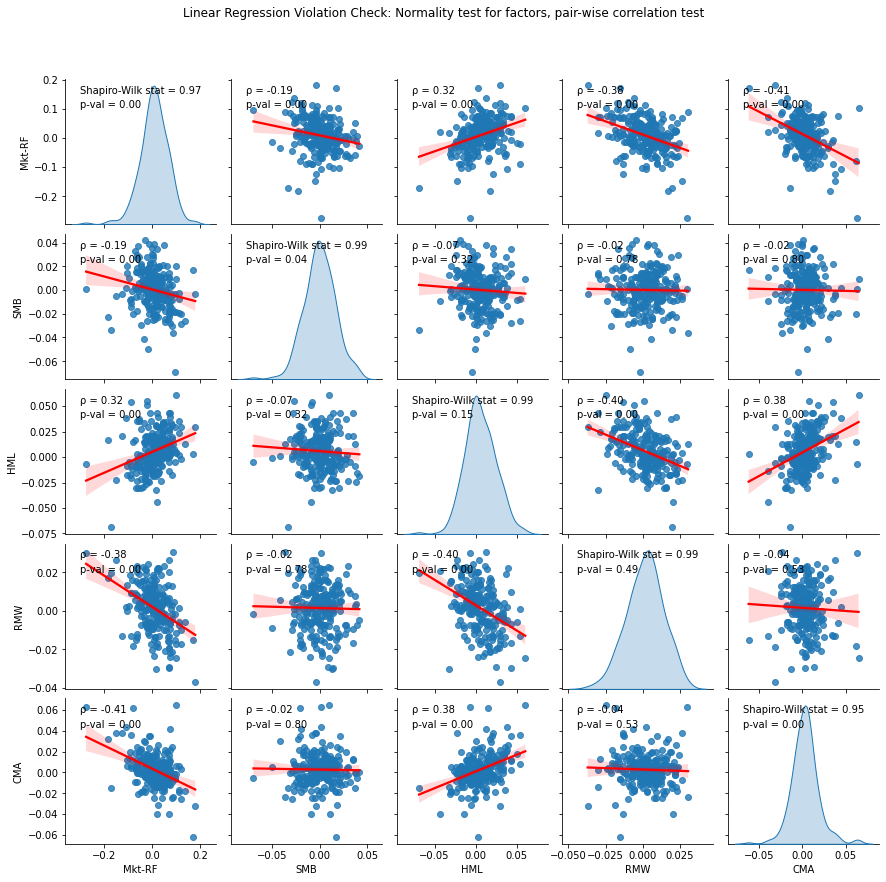

In [226]:
# 4: Eye ball the distributions...
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import pearsonr
from scipy.stats import shapiro

# Function we will call to add R2 and p-val to the off-diagonal cells of the pair plot
def R2func(x, y, hue=None, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    _, _, r, p, _ = stats.linregress(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'ρ = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)
    ax.annotate(f'p-val = {p:.2f}', xy=(.1, .8), xycoords=ax.transAxes)

# Function we will call to add normality test stat and p-val to diagnonal cells of pair plot
# Note that inputs to linear regression are not required to be normally distributed.
def normalityfunc(x, hue=None, ax=None, **kws):
    """Plot the Shapiro Wilk p-value in the top left hand corner of diagonal cells."""
    stat, p = shapiro(x)
    ax = ax or plt.gca()
    ax.annotate(f'Shapiro-Wilk stat = {stat:.2f}', xy=(.1, .9), xycoords=ax.transAxes)
    ax.annotate(f'p-val = {p:.2f}', xy=(.1, .8), xycoords=ax.transAxes)

# Generate pairplot
pp = sns.pairplot(df_ff_factors, kind='reg', diag_kind='kde',
             plot_kws={'line_kws':{'color':'red'}})

# Run the R2func for all off diagnonal cells, and normalityfunc for the diagonal ones...
pp.map_lower(R2func)
pp.map_upper(R2func)
pp.map_diag(normalityfunc)

# Title...
pp.fig.subplots_adjust(top=0.9) # adjust the Figure in rp

pp.fig.suptitle('Linear Regression Violation Check: Normality test for factors, pair-wise correlation test')

plt.show()


### Simple Factor model

We now specify our factor model using OLS regression, with the option of robust standard error. We will wrap this up as a function, so as we can call it multiple times over the study term, to generate trades for each month.

Note that we sanity check parameters, to provide basic checks, and we analyse the residuals produced by the model to ensure residuals are normally distributed (using a SHapiro-Wilk test in this case, with the option of generating a scatter plot in the function too).
Let us run the function, using our 5 factor regression on the first security in the dataset, column=0.

Many refinements can be made to this simple model.

In [277]:
# Packages to use...
import statsmodels
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

# Function that will run our OLS model, for a given security, over a given period
# Note the two optional parameter... 
#   use_robust_cm: estimate from a robust covariance matrix
#   plot_residual_scatter: which will generate a scatter plot of our residuals (y vs y_hat)
def factormodel_train_single_security(sec_col_no: int,
                     df_tb3ms: pd.DataFrame,
                     df_sec_rets: pd.DataFrame,
                     df_ff_factors: pd.DataFrame,
                     date_start: int,
                     date_end: int,
                     use_robust_cm: bool = False,
                     plot_residual_scatter: bool = False) -> (object, np.array, np.array, float, float):
  
  # sanity
  if date_start < date_end: 
    raise TypeError("Latest date is date=0, date_start is > date_end")
  if df_ff_factors.shape[0] < df_ff_factors.shape[1]:
    raise TypeError("Must pass factor returns as columns not rows")  
  if df_ff_factors.index[0] != df_sec_rets.index[0]:
    raise TypeError("Dates misaligned")  
  if df_tb3ms.index[0] != df_sec_rets.index[0]:
    raise TypeError("Dates misaligned")  

  # Get X and y data...
  # NB: Security returns... deduct Rf
  y_train = [df_sec_rets.iloc[i, sec_col_no] - df_tb3ms.iloc[i, 0] for i in range(date_end,date_start)]
  X_train = df_ff_factors.iloc[date_end:date_start, :]
  
  # Instantiate and train OLS model
  X_train = sm.add_constant(X_train) #<< statsmodels requires we manually add an intercept.
  ols_model = OLS(y_train, X_train)
  ols_model = ols_model.fit()

  # Optional ... Use heteroskedasticity-autocorrelation robust covariance?
  if use_robust_cm:
      ols_model = ols_model.get_robustcov_results()

  # Predict in sample
  y_hat = ols_model.predict(X_train)
  resid = y_train-y_hat

  # In sample prediction: Examine residuals for normality... 
  # NB: The null hypothesis (H0) states that the variable is normally distributed, 
  # and the alternative hypothesis (H1) states that the variable is NOT normally distributed.  
  sw_stat, sw_p = shapiro(resid)
  
  # Optional ...
  if plot_residual_scatter == True:   
    # square plot     
    fig, ax = plt.subplots()
    ax.scatter(y_train-y_hat, y_hat)        
    ax.set_aspect(aspect=1)
    plt.title('Residual Plot: Shapiro-Wilk p-val: ' + str(round(sw_p, 2)))
    plt.show()

  return (ols_model, y_train, y_hat, sw_stat, sw_p)

In [278]:
# Forecast the expected return of a single stock
def factormodel_forecast_ER(df_stock_factor_loadings: pd.DataFrame,
                                    df_ff_factors: pd.DataFrame,
                                    r_f: float, 
                                    date_start: int,
                                    date_end: int) -> np.array:

  #date_start = 35
  #date_end = 0
  #r_f = 0.01
  #df_stock_factor_loadings=pd.DataFrame(ols_model.params)

  # sanity
  if date_start < date_end: 
    raise TypeError("Latest date is date=0, date_start is > date_end")
  if df_ff_factors.shape[0] < df_ff_factors.shape[1]:
    raise TypeError("Must pass factor returns as columns not rows")  
  if df_ff_factors.shape[1] != df_stock_factor_loadings.shape[0]-1: #Include the intercept dimension
    raise TypeError("Must pass same number of factors for security as the df_ff_factors")  

  # Factor returns to assume
  factor_excess_returns = df_ff_factors.iloc[date_end:date_start, :].sort_index()
  factor_excess_returns = np.array(1+factor_excess_returns.iloc[date_end:date_start, :]).prod(axis=0)
  factor_excess_returns = factor_excess_returns ** (12/(date_start-date_end))-1

  # Stock Forecast E(R)_i,t+h
  E_R = np.dot(factor_excess_returns.T, df_stock_factor_loadings.iloc[1:, :])

  #Only add constant and r_f to (non zero returns) populated securities
  non_zero_secs = E_R != 0
  E_R[non_zero_secs] = E_R[non_zero_secs] + r_f +  df_stock_factor_loadings.loc['const', non_zero_secs]

  return E_R


## Bias Alert: Complexity Bias (Training Window Size)
Part of model validation in timeseries domains is to run historic simulations, and to avoid data snooping bias, we need to use a small subset of the data we have. A relatively long history of returns is required to learn a linear regrssion model with many input variables[1], less for a classification model. If we use a ML model, which generally have more parameters, we need even more data for training. In short, we may not have high enough frequency data to train a stable model. This problem is exaccerbated when running simulations, as to avoid data snooping bias we must only use a subset of our full dataset that preceeds each simulation date.   

The more sampeles we have, and the more accurate the data, the more accurate our model will be. The more data we have the more features and model parameters  (ie complexity) we can employ to approximate our target function. However, there is a balanmcing act between complexity and the data available, and if our model becomes too complex for the amount of data we will likely overfit to the data, and our model will not perform well out of sample. It will be a bad predictor. 

So how much data do we need for our chosen model? And what is the maximum number of features we should use?


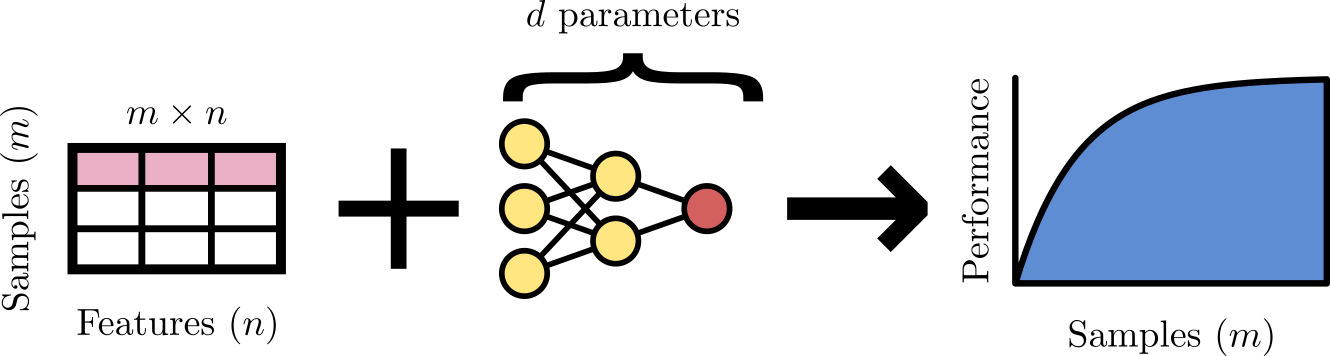


### Model complexity1: Instances vs features and classes used
A rule of thumb for the number of instances, n, needed to train a stable model with K input features, for a classification model with C categories to classify:

n ≥ 10 K · C,

instances. For a regression model:

n ≥ 50 K,

instances are suggested.


### Model complexity2: Instances vs parameters
A rule of thumb for the limit on number of parameters, ¦θ¦, our model should have, given the size of our training data [3], we suggest this: 

¦θ¦ ≤ n/10 


[1] Robert C. Merton, “On Estimating the Expected Return on the Market: An Exploratory Investigation,” Journal of Financial Economics, 8 (1980), pp. 323–361.

[2] Valliappa Lakshmanan, Sara Robinson, and Michael Munn. Machine learning design patterns. O’Reilly Media, 2020

[3] Kevin P. Murphy, Probabilistic machine learning: an introduction. MIT press, 2022

In [229]:
#***********************************************************************
#*** Complexity bias Sanity Check!***
#***********************************************************************  
def bias_complexity_check_regression(no_of_instances: int,
                          no_of_features: int = 0,
                          no_of_parameters: int = 0) -> (bool, int, int):

  failed = False
  cb_K = no_of_features
  cb_n = no_of_instances
  
  # 1. Feature complexity: n ≥ 50 K
  if cb_n > 50 * cb_K:
    failed = True
  
  feature_max = int(round(cb_n / 50, 0))

  # 2. Parameter complexity: ¦θ¦ ≤ n/10
  #
  # The number of model parameters (ie weights) should observe the constraint
  # wrt training instances, n, features, K:
  #
  # |theta| >= n/10  
  param_max = int(round(cb_n / 10, 0))
  
  if no_of_parameters > param_max:
    failed = True

  return (failed, feature_max, param_max)


### Vectorized Simple Factor model

The func "factor_model_single_security" is a simplified approach, calculating betas for one stock at a time. We show the vectorized version of the same function below, which can calculate many stock level betas at a time for a huge speed up



In [256]:
# Function that will run a vectorized OLS model, for a given security, over a given period
# Vectorized OLS regression is far faster. 
# Note the two optional parameter... 
#   use_robust_cm: estimate from a robust covariance matrix
#   plot_residual_scatter: which will generate a scatter plot of our residuals (y vs y_hat)
def factormodel_train_manysecurities(df_tb3ms: pd.DataFrame,
                     df_sec_rets: pd.DataFrame,
                     df_ff_factors: pd.DataFrame,
                     date_start: int,
                     date_end: int) -> (object, np.array, np.array):

  # sanity
  if date_start < date_end: 
    raise TypeError("Latest date is date=0, date_start is > date_end")
  if df_ff_factors.shape[0] < df_ff_factors.shape[1]:
    raise TypeError("Must pass factor returns as columns not rows")  
  if df_ff_factors.index[0] != df_sec_rets.index[0]:
    raise TypeError("Dates misaligned")  
  if df_tb3ms.index[0] != df_sec_rets.index[0]:
    raise TypeError("Dates misaligned")  

  # Get X and y data...
  # NB: Security returns from date_end to date_start... deduct Rf
  y_train = np.array([df_sec_rets.iloc[i, :] - df_tb3ms.iloc[i, 0] for i in range(date_end,date_start)])
  X_train = np.array(df_ff_factors.iloc[date_end:date_start, :]).astype('float')

  # Prepare matrices for linalg, and OLS
  intercept = np.ones((date_start-date_end,1))
  X = np.concatenate((intercept, X_train), axis=1)

  # Flag nan containing security returns
  cols_non_nan = ~np.isnan(y_train).any(axis=0)
  y = y_train[:,cols_non_nan]

  # Sanity Check: Biases ************************
  if bias_complexity_check_regression(no_of_instances=X_train.shape[0],
                                      no_of_features=X_train.shape[1],
                                      no_of_parameters=X_train.shape[1]) == True:
    raise TypeError("Complexity bias checks failed")  
  # Sanity Check: Biases ************************

  # Train model
  ols_betas, resid, rank, sigma = np.linalg.lstsq(X,y)  

  # Predict in sample
  y_hat = np.dot(X, ols_betas)
  resid = y - y_hat

  # We removed nan rows... Rebuild to a full vector
  ols_betas_final = pd.DataFrame(np.zeros((ols_betas.shape[0], y_train.shape[1])))
  ols_betas_final.loc[:, cols_non_nan] = ols_betas

  ols_betas_final.columns = df_sec_rets.columns
  ols_betas_final.index = ['const'] + df_ff_factors.columns.to_list()
  return (ols_betas_final, y, y_hat)


In [231]:
df_ff_factors

,Mkt-RF,SMB,HML,RMW,CMA
Unnamed: 0,,,,,
202209,-0.1078,0.0019,0.0383,0.0019,0.0440
202208,0.0075,0.0031,0.0087,-0.0236,0.0040
202207,0.0024,0.0078,0.0147,0.0009,0.0119
202206,-0.0677,0.0012,-0.0099,-0.0151,0.0038
202205,0.0026,-0.0154,-0.0085,-0.0014,0.0166
...,...,...,...,...,...
200306,0.0588,0.0001,0.0127,-0.0097,-0.0052
200305,0.0708,0.0047,0.0116,-0.0162,0.0103
200304,0.0922,-0.0182,0.0076,0.0045,-0.0017


Let us call out function using security in column=0, and using the full term of the data available. We will also opt to generate a residual plot by setting plot_residual_scatter=True.
We also print the summary stats for the regression.
Finally we will set a sanity check for normality of the redisuals. If the Shapiro-Wilk test produces a p-val of >10\% we can accept the null hypothesis, implying that the distribution of residuals is normal. 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


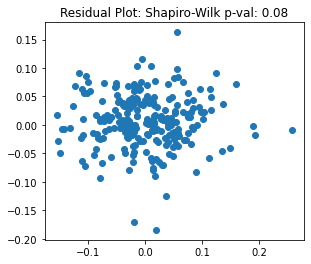

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.330
Model:                            OLS   Adj. R-squared:                  0.316
Method:                 Least Squares   F-statistic:                     22.71
Date:                Fri, 04 Nov 2022   Prob (F-statistic):           1.68e-18
Time:                        17:48:54   Log-Likelihood:                 304.47
No. Observations:                 236   AIC:                            -596.9
Df Residuals:                     230   BIC:                            -576.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0049      0.005     -1.022      0.3

TypeError: ignored

In [283]:

# Run our function on the first security (sec_col_no=0), returning only the model object, and Shapiro-Wilk stat and p-value
ols_model, y, y_hat, sw_t, sw_p = factormodel_train_single_security(sec_col_no=0, 
                                             df_tb3ms=df_tb3ms, 
                                             df_sec_rets=df_sec_rets, 
                                             df_ff_factors=df_ff_factors, 
                                             date_start=df_ff_factors.shape[0], 
                                             date_end=0, 
                                             plot_residual_scatter=True)
# Examine the fit, coefficients and OLS analytics.
print(ols_model.summary())

# Forecast E(R) for this security.
E_R = factormodel_forecast_ER(df_stock_factor_loadings=pd.DataFrame(ols_model.params), 
                                df_ff_factors=df_ff_factors, 
                                r_f=df_tb3ms.iloc[0,0],
                                date_start=df_ff_factors.shape[0], 
                                date_end=0,)

print("Expected Return Forecast for Stocks")
print(E_R)

# Check for normality in the residuals
if sw_p < 0.10:
  raise TypeError("Residuals appear to be non-normal!")  

### Factor Model Applied Over Time
We now use out function to step over time, using a 36month sliding window. We start in the early time period and end at the most recent period, generating a expected returns for each stock (with a full dataset of returns) as we go.
At the end of this process we will be able to say which stocks we favor, and which we do not in each time period. 



In [270]:
# Loop through time, from the earliest period, to the latest, calculating E(R) for every stock we have data for in each time period
# We will generate a DataFrame containing the expected returns for each stock in each period as we go.
def factormodel_sim_ER(df_tb3ms: pd.DataFrame,
                     df_sec_rets: pd.DataFrame,
                     df_ff_factors: pd.DataFrame,
                    window_size: int = 50,
                    factor_return_history: int = 12) -> pd.DataFrame:

  # E(R) for each stock, in each time period
  df_stock_ER = pd.DataFrame(np.zeros((df_sec_rets.shape[0]-window_size, df_sec_rets.shape[1])))
  df_stock_ER.index = df_sec_rets.index[0:df_sec_rets.shape[0]-window_size]
  df_stock_ER.columns = df_sec_rets.columns[0:df_sec_rets.shape[1]].astype(int)
  #
  df_stock_SW_pval = df_stock_ER.copy(deep=True)

  #Step through time... earliest to latest.
  for i in range(df_ff_factors.shape[0]-window_size-1, -1, -1):
    # Run our function, returning only the result object
    ols_coefs, _, _ = factormodel_train_manysecurities(df_tb3ms=df_tb3ms, 
                                              df_sec_rets=df_sec_rets, 
                                              df_ff_factors=df_ff_factors, 
                                              date_start=i+window_size, #<< Note we pass in the start date here
                                              date_end=i)  #<< Note we pass in the end date here
    
    # Generate E(R) from our stock level factor model...      
    # Factor return assumption      
    E_R = factormodel_forecast_ER(df_stock_factor_loadings=pd.DataFrame(ols_coefs), 
                                    df_ff_factors=df_ff_factors,
                                    r_f=df_tb3ms.iloc[i, 0],
                                    date_start=i+factor_return_history,
                                    date_end=i) 
    df_stock_ER.iloc[i,:] = E_R

  return df_stock_ER 

# Run the function with our data
df_stock_ER = factormodel_sim_ER(df_tb3ms=df_tb3ms, 
                   df_sec_rets=df_sec_rets,
                   df_ff_factors=df_ff_factors,
                   window_size=50)

df_stock_ER

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


TICKER,1,2,3,4,5,6,7,8,9,10,...,1233,1234,1235,1236,1237,1238,1239,1240,1241,1242
202209,0.142797,0.0,0.0,0.0,0.0,0.0,0.0,-0.096746,0.041255,-0.242044,...,0.085270,-0.392662,0.0,0.0,-0.120556,-0.256532,-0.631394,-0.227003,0.085531,-0.416628
202208,0.137721,0.0,0.0,0.0,0.0,0.0,0.0,0.060016,0.118895,-0.146374,...,0.061285,-0.225907,0.0,0.0,-0.071797,-0.134606,-0.432519,-0.134320,0.042657,-0.267507
202207,0.132974,0.0,0.0,0.0,0.0,0.0,0.0,-0.035148,0.069083,-0.082575,...,0.037099,-0.167186,0.0,0.0,-0.049306,-0.102778,-0.446444,-0.140159,0.026259,-0.280377
202206,0.103218,0.0,0.0,0.0,0.0,0.0,0.0,-0.077016,0.072957,-0.073897,...,0.019926,-0.172171,0.0,0.0,-0.076457,-0.068016,-0.422407,-0.152868,-0.024125,-0.283891
202205,0.157118,0.0,0.0,0.0,0.0,0.0,0.0,-0.004190,0.181579,0.051791,...,0.050970,-0.157918,0.0,0.0,-0.021311,-0.032222,-0.331481,-0.087554,0.081737,-0.224556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200708,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
200707,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
200706,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
200705,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [271]:
# Establish trades for 6monthly rebalances
def trades_topquantile_generate(df_stock_ER: pd.DataFrame,
                            rebalance_freq: int,
                            quantile_to_buy: float = 0.2) -> pd.DataFrame:

  # Initialise df_trades
  df_trades = pd.DataFrame(np.zeros((df_stock_ER.shape[0],df_stock_ER.shape[1])), columns=df_stock_ER.columns, index=df_stock_ER.index)
  
  # loop through time... start to end.
  for i in range(df_stock_ER.shape[0], 0, -1):
    valid_secs = ~df_stock_ER.iloc[i, :].isna()
    period_ER = df_stock_ER.iloc[i, :].sort_values(axis=1)

    qu = df_stock_ER.iloc[i, valid_secs].percentile(q=quantile_to_buy, axis=1)
    no = df_stock_ER[df_stock_ER.iloc[i, valid_secs] > qu].count()

    #Add trade
    df_stock_ER[i,:] = 0
    df_stock_ER[df_stock_ER.iloc[i, valid_secs] > qu] = 1/no


#Call function to establish simple positions
df_trades = trades_topquantile_generate(df_stock_ER=df_stock_ER, rebalance_freq=6, quantile_to_buy=0.2)
run_sim(df_trades=df_trades, df_returns=df_returns)

IndexError: ignored

In [272]:
# Simulation routine
def run_sim(df_trades: pd.DataFrame,
            df_returns: pd.DataFrame) -> pd.DataFrame:
  # Sanity
  # Period1 must have a 100% allocation...
  if df_trades.iloc[-1,:] != 1:
    raise TypeError('df_trades first period must sum to 1')
  # All subsequent periods must have trades netting to zero...
  if df_trades.sum(axis=0).round(2).sum() != 0:
    raise TypeError('df_trades not all period have trades summing to zero; all buys must have corresponding sells')

  # Ini CAGR of each security as the initial trade
  df_sec_cagr = df_trades.iloc[-1,:].copy(deep=True)

  # Step through time
  for i in range(df_trades.shape[0]-1, -1, -1):
    #Trades in this period? Not nan, >0
    trade_sell_flag = ((df_trades.iloc[i,:] != np.nan) & (df_trades.iloc[i,:] < 0))
    trade_sell_cols = df_trades.column.loc[trade_sell_flag == True]
    tot_trades = df_trades.loc[i, trade_sell_cols].sum()  
    tot_cagr = df_sec_cagr[i+1, trade_sell_cols].sum()  
      
    # calculate terminal val of sells
    trade_sell_flag = (df_trades == True)

    for j in range(0, df_trades.shape[1]-1):
      
      # nan means no trade in this security
      if df_trades.iloc[i,j] == np.nan:
        df_sec_cagr.iloc[i,j] = df_sec_cagr.iloc[i+1,j] * (1+df_returns.iloc[i,j])
      elif df_trades.iloc[i,j] > 0:
        df_sec_cagr.iloc[i,j] = tot_cagr * df_trades.iloc[i,j]
      elif df_trades.iloc[i,j] < 0:
        df_sec_cagr.iloc[i,j] = 0

  return tot_cagr


## Bias Alert: Certainty bias

Any opinion offered about the probability, likelihood, certainty, or similar property for a hypothesis cannot be derived from statistical methods alone. In particular, significance tests and confidence intervals do not by themselves provide a logically sound basis for concluding an effect is present or absent with certainty or a given probability. This point should be borne in mind whenever one sees a conclu
sion framed as a statement of probability, likelihood, or certainty about a hypothesis. Information about the hypothesis beyond that contained in the analyzed data and in conventional statistical models (which give only data probabilities) must be used to reach such a conclusion; that information should be explicitly acknowledged and described by those offering the conclusion. Bayesian statistics offers methods that attempt to incorporate the needed information directly into the statistical model; they have not, however, achieved the popularity of P values and confidence intervals, in part because of philosophical objections and in part because no conventions have become established for their use.

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4877414/

## Bias Alert: Endogenous bias
Endogeneity bias is not a simple violation and there is no easy statistical solution. It has serious consequences for outcomes, where in the presence of endogenous variables OLS learns biased and inconsistent parameters. P-values can be seriously misleading. All it takes is one endogenous variable to seriously distort ALL OLS parameters.
https://artnet.unescap.org/tid/artnet/mtg/gravity09_tues3.pdf

One potentially concerning endogeneity is self-fulfilling prophecy of factor investing, where stocks with high correlations to commonly used factors would cause investments in those stocks, causing price appreciation, affirming that the correlations with those factors caused the price rises.


# 2. Machine Learning Enhanced Traditional Quantitative Approach

We now examine using "first generation" machine learning tools, applied in a traditional quantative framework.

## 2a. Factor Approach with Non-linear Regression

The ML approach is somewhat different to the traditional linear factor approach. To avoid ovefitting, ML is typically separated into a train and test data. However, if we are careful about limiting model complexity (complexity bias) and if we are running a historic simulation, this is less important.

The following neural net has been heuristically tuned, ie by trial and error, and this process took about 30minutes to complete. If you try changing the settings in the MLPRegressor's fit function yourself, you will see how variable the predictions are from this model. There is huge sensitivity to the typs of normalization use, the activation function used and so on. All this implies a lack of stability. 

## Bias Alert: Normalization Data Snooping bias

For neural nets we almost always need to normalize (or standardize) the input data. There is room for a weak form of data snooping bias though, in historic simulations. 
We can either normlize by row (ie across a given stock's datapoints), so that each column is in proportion to the row. Or we can normlize by column. 

For stock selection applications row level normalization makes less sense, because taking PE ratio as an example, you want to compare one stock's PE ratio versus the PE ratio of all others; ie column normalize. It makes little sense to row normalize, where a stock's PE is scaled against the same stock's EBITDA/EV.  
The bias arises when we column normalize (or standardize) training data to train our model, and then pass in new data for forecasting, which may contain different min and maxes in each column. In this case all the column scalings will slightly change if the min max range changes from the training data.
In this case we can either live with the inaccuracy, or save the min-max training range and normalize the new data to the training range, capping the min/max at the training min/max, or allowing the min/max to exceed the -1/+1 range typically used for min/max scaling.


## Bias Alert: Repeated testing (multiplicity) bias

Complex machine learning approaches generally have many hyperparameters, such as neural nets, with the number of hidden nodes, the learning rate, optimizer used, activation function and so on. It is standard practices to conduct a grid search of these hyper parameters, known as hyperparameter tuning, until we find the optimum comdination. This is a problem if we are hypothesis testing the results of our model, for instance sampling the R2, and F-stat of the goodness of fit of our prediction, because the p-val is calculated to assume the probability of one test being conducted. This is known as multiplicity bias.   

Applying many tests in a single study results in an increased probability of detecting a significant finding just by chance (the problem of multiplicity). It then discusses some of the methods that have been proposed for correcting for multiplicity, including single-step procedures (e.g., Bonferroni); multistep procedures, such as those of Holm, Hochberg, and Šidák; false discovery rate control; and resampling approaches. 

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3015194/

In [280]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

# Neural net (MLP) model, extends our factor model to non-linear regression
def nonlinfactor_train_single_security(sec_col_no: int,
                     df_tb3ms: pd.DataFrame,
                     df_sec_rets: pd.DataFrame,
                     df_ff_factors: pd.DataFrame,
                     date_start: int,
                     date_end: int,
                     use_robust_cm: bool = False,
                     plot_residual_scatter: bool = False) -> (object, np.array, np.array, float, float):

  #sec_col_no=0
  #date_start=50
  #date_end=0
  #plot_residual_scatter=True

  # sanity
  if date_start < date_end: 
    raise TypeError("Latest date is date=0, date_start is > date_end")
  if df_ff_factors.shape[0] < df_ff_factors.shape[1]:
    raise TypeError("Must pass factor returns as columns not rows")  
  if df_ff_factors.index[0] != df_sec_rets.index[0]:
    raise TypeError("Dates misaligned")  
  if df_tb3ms.index[0] != df_sec_rets.index[0]:
    raise TypeError("Dates misaligned") 

  # Get X and y data...
  # NB: Security returns... deduct Rf
  y_train = [df_sec_rets.iloc[i, sec_col_no] - df_tb3ms.iloc[i, 0] for i in range(date_end,date_start)]
  X_train = df_ff_factors.iloc[date_end:date_start, :]
  #
  X_train = X_train.to_numpy()
  y_train = np.array(y_train)

  # Normalize X data...
  X_train_norm = StandardScaler().fit_transform(X_train)

  # Instantiate and train neural net model
  _, _, hidden_layer_sizes = bias_complexity_check_regression(no_of_instances=X_train_norm.shape[0],
                                      no_of_features=X_train_norm.shape[1])
  
  nn_model = MLPRegressor(hidden_layer_sizes=(hidden_layer_sizes), max_iter=500, learning_rate_init=0.01, random_state=0, solver='lbfgs', tol=0.001,  activation='logistic')
  nn_model = nn_model.fit(X=X_train_norm, y=y_train) 

  # Predict in sample
  y_hat = nn_model.predict(X_train_norm)
  resid = y_train-y_hat

  # Sanity Check: Biases ************************
  if bias_complexity_check_regression(no_of_instances=X_train_norm.shape[0],
                                      no_of_features=X_train_norm.shape[1],
                                      no_of_parameters=sum(len(x) for x in nn_model.coefs_)) == True:
    raise TypeError("Complexity bias checks failed")  
  # Sanity Check: Biases ************************

  # In sample prediction: Examine residuals for normality... 
  # NB: The null hypothesis (H0) states that the variable is normally distributed, 
  # and the alternative hypothesis (H1) states that the variable is NOT normally distributed.  
  sw_stat, sw_p = shapiro(resid)

  # Optional ...
  if plot_residual_scatter == True:   
    # square plot     
    fig, ax = plt.subplots()
    ax.scatter(y_train-y_hat, y_hat)        
    ax.set_aspect(aspect=1)
    plt.title('Residual Plot: Shapiro-Wilk p-val: ' + str(round(sw_p, 2)))
    plt.show()
    
  return (nn_model, y_train, y_hat, sw_stat, sw_p) 

In [281]:
# Forecast the expected return of a single stock
def nonlinfactor_forecast_ER(nn_model: object,
                                    df_ff_factors: pd.DataFrame,
                                    r_f: float, 
                                    date_start: int,
                                    date_end: int) -> float:

    #date_start = 35
    #date_end = 0
    #r_f = 0.01
    #df_stock_factor_loadings=pd.DataFrame(ols_model.params)

    # sanity
    if date_start < date_end: 
      raise TypeError("Latest date is date=0, date_start is > date_end")
    if df_ff_factors.shape[0] < df_ff_factors.shape[1]:
      raise TypeError("Must pass factor returns as columns not rows")  
    if nn_model is None: 
      raise TypeError("Must pass instantiated nn_model object")  

    # Factor returns to assume, annualized...
    factor_excess_returns = df_ff_factors.iloc[date_end:date_start, :].sort_index()
    factor_excess_returns = np.array(1+factor_excess_returns.iloc[date_end:date_start, :]).prod(axis=0)
    factor_excess_returns = factor_excess_returns ** (12/(date_start-date_end))-1

    #*Quirk ... Sklearn needs 2D array to predict - insert zero row...
    blank_row = np.repeat([999999], factor_excess_returns.shape[0])
    factor_excess_returns = np.vstack((factor_excess_returns, blank_row))

    # Stock Forecast E(R)_i,t+h
    E_R = nn_model.predict(factor_excess_returns)

    #*Quirk ... Sklearn needs 2D array to predict - remove inserted row    
    E_R = E_R[0]
    if E_R != 0:
      E_R = E_R + r_f

    return E_R

Run our functions on one security first to examine the results... same security as we rtun the linear model on.

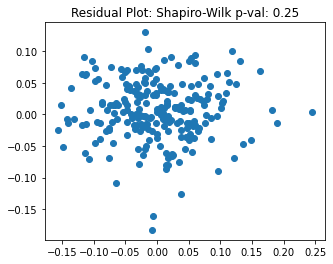

0.32486906017743367
Expected Return Forecast for Stocks
0.01469207035428015


In [282]:
# Run our function on the first security (sec_col_no=0), returning only the model object, and Shapiro-Wilk stat and p-value
nn_model, y, y_hat, sw_t, sw_p = nonlinfactor_train_single_security(sec_col_no=0, 
                                             df_tb3ms=df_tb3ms, 
                                             df_sec_rets=df_sec_rets, 
                                             df_ff_factors=df_ff_factors, 
                                             date_start=df_ff_factors.shape[0], 
                                             date_end=0, 
                                             plot_residual_scatter=True)
# Examine the fit, coefficients and OLS analytics.
print(r2_score(y_true=y, y_pred=y_hat))

# Forecast E(R) for this security.
E_R = nonlinfactor_forecast_ER(nn_model=nn_model, 
                                df_ff_factors=df_ff_factors, 
                                r_f=df_tb3ms.iloc[0,0],
                                date_start=df_ff_factors.shape[0], 
                                date_end=0,)

print("Expected Return Forecast for Stocks")
print(E_R)

# Check for normality in the residuals
if sw_p < 0.10:
  raise TypeError("Residuals appear to be non-normal!") 

Run on all securities now...

In [239]:
# Loop through time, from the earliest period, to the latest, calculating E(R) for every stock we have data for in each time period
# We will generate a DataFrame containing the expected returns for each stock in each period as we go.
def nonlinfactor_sim_ER(df_tb3ms: pd.DataFrame,
                     df_sec_rets: pd.DataFrame,
                     df_ff_factors: pd.DataFrame,
                     window_size: int = 50,
                     factor_return_history: int = 12) -> pd.DataFrame:

  # E(R) for each stock, in each time period
  df_stock_ER = pd.DataFrame(np.zeros((df_sec_rets.shape[0]-window_size, df_sec_rets.shape[1])))
  df_stock_ER.index = df_sec_rets.index[0:df_sec_rets.shape[0]-window_size]
  df_stock_ER.columns = df_sec_rets.columns[0:df_sec_rets.shape[1]].astype(int)
  #
  df_stock_SW_pval = df_stock_ER.copy(deep=True)

  #Step through time... earliest to latest.
  for i in range(df_ff_factors.shape[0]-window_size-1, -1, -1):
    # Loop through all securities in turn ... slow.
    for j in range(0, df_sec_rets.shape[1]):
      # Only run populated securities...
      if df_sec_rets.iloc[i:i+window_size, j].isna().sum() == 0:
        # Run our function, returning only the result object
        nn_model, _, _, _, _ = nonlinfactor_train_single_security(sec_col_no=j,
                                                  df_tb3ms=df_tb3ms, 
                                                  df_sec_rets=df_sec_rets, 
                                                  df_ff_factors=df_ff_factors, 
                                                  date_start=i+window_size, #<< Note we pass in the start date here
                                                  date_end=i)  #<< Note we pass in the end date here
        
        # Generate E(R) from our stock level factor model...      
        # Factor return assumption      
        E_R = nonlinfactor_forecast_ER(nn_model=nn_model, 
                                        df_ff_factors=df_ff_factors,
                                        r_f=df_tb3ms.iloc[i, 0],
                                        date_start=i+factor_return_history,
                                        date_end=i) 
        df_stock_ER.iloc[i,j] = E_R

    print(str(i))

  return df_stock_ER 

# Run the functin with our data
df_stock_ER = nonlinfactor_sim_ER(df_tb3ms=df_tb3ms, 
                   df_sec_rets=df_sec_rets,
                   df_ff_factors=df_ff_factors,
                   window_size=50)

df_stock_ER

185
184
183
182
181
180
179
178
177
176
175
174
173
172
171
170
169
168
167
166
165
164
163
162
161
160
159
158
157
156
155
154
153
152
151
150
149
148
147
146
145
144
143
142
141
140
139
138
137
136
135
134
133
132
131
130
129
128
127
126
125
124
123
122
121
120
119
118
117
116
115
114
113
112
111
110
109
108
107
106
105
104
103
102
101
100
99
98
97
96
95
94
93
92
91
90
89
88
87
86
85
84
83
82
81
80
79
78
77
76
75
74
73
72
71
70
69
68
67
66
65
64
63
62
61
60
59
58
57
56
55
54
53
52
51
50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
0


TICKER,1,2,3,4,5,6,7,8,9,10,...,1233,1234,1235,1236,1237,1238,1239,1240,1241,1242
202209,-0.019182,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,-0.022221,0.041968,-0.012621,...,-0.006411,-0.054074,0.0,0.0,-0.005563,0.003274,-0.021939,-0.012982,-0.055252,-0.043119
202208,-0.013126,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,-0.000382,0.047662,0.022697,...,-0.004790,0.015558,0.0,0.0,0.001286,0.012062,-0.006665,-0.005732,-0.026907,-0.030119
202207,-0.017286,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,-0.007446,0.039006,0.005818,...,-0.007681,-0.043883,0.0,0.0,-0.001789,0.009784,-0.008242,-0.014262,-0.052496,-0.026126
202206,-0.018840,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,-0.016860,0.033583,-0.042771,...,-0.009041,0.027361,0.0,0.0,-0.002503,0.001835,-0.007025,-0.017383,-0.035722,-0.032250
202205,-0.009971,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,-0.004975,0.035762,-0.055734,...,-0.006251,0.029685,0.0,0.0,0.005122,0.000458,-0.007000,-0.013070,-0.043760,-0.024059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200708,0.017870,0.013235,0.082418,0.050428,0.016087,0.023063,0.0,0.063254,0.083269,0.062388,...,0.000000,0.000000,0.0,0.0,0.000000,0.031710,0.000000,0.044030,0.000000,0.000000
200707,0.017337,0.014824,0.081819,0.052254,0.016008,0.020993,0.0,0.061613,0.089490,0.064339,...,0.000000,0.000000,0.0,0.0,0.000000,0.035694,0.000000,0.047801,0.000000,0.000000
200706,0.018842,0.022735,0.084059,0.056863,0.016104,0.032536,0.0,0.059884,0.088920,0.064386,...,0.000000,0.000000,0.0,0.0,0.000000,0.039772,0.000000,0.053382,0.000000,0.000000
200705,0.023500,0.033122,0.096669,0.059651,0.018265,0.035455,0.0,0.062833,0.085530,0.070073,...,0.000000,0.000000,0.0,0.0,0.000000,0.038692,0.000000,0.055585,0.000000,0.000000


### Bias Alert: Complexity Bias
Using neural net is way too complex.
Limited number of features... limited number of data point.
Number of model paramters/data points  =


## 2b. Classification Approach

# 3. Interpretable Machine Learning Approach


# Stage1. Business Case 

Define key performance indicators (KPIs). 
Data needed, outcomes, model risk level, communication strategy.
Regulatory and Compliance issues 


In [ ]:
df_raw.columns

Index(['checking_status', 'duration', 'credit_history', 'purpose',
       'credit_amount', 'savings_status', 'employment',
       'installment_commitment', 'personal_status', 'other_parties',
       'residence_since', 'property_magnitude', 'age', 'other_payment_plans',
       'housing', 'existing_credits', 'job', 'num_dependents', 'own_telephone',
       'foreign_worker', 'class'],
      dtype='object')

There is clearly a bias in the dataset, but to expand upon this we can use a Chi2 test to examine whether the observed "bad" credits we see in female rows, is statistically significant to the expected difference we see in male rows.

It is possible that this bias is proxied by another data item in the dataset. **We will come back to this issue later**.

# Stage2: Exploratory Data Analysis

## Data Wrangling and Preprocessing

Data Wrangling: As we have shown in previous chapters we need to convert categorical data into one-hot-encodings, clean characters from numeric data columns, carry out type conversions into numeric datatypes... The following cell shows the appropriate data wrangling to get our data into a good shape. 

In [ ]:
# list categorical columns...
cat_cols =['checking_status', 'purpose', 'credit_history', 'savings_status', 'employment', 'other_parties', 'property_magnitude', 'other_payment_plans','housing','job','own_telephone']

# One hot encoding of catagorical variables...
df[cat_cols].astype("category")
one_hot_encodings = pd.get_dummies(df[cat_cols])

#Combine dfs
df = pd.concat([df, one_hot_encodings], axis=1)

#remove categorical columns...
df = df.drop(columns=cat_cols)

#Data wrangling..... get types and bad values sorted out

# Remove characters in numeric columns (note that the data type was set, by the open_csv function to object, 
# so we first convert to string before running the replace function (which can only be fun on str types)
df['foreign_worker'] = df['foreign_worker'].str.replace('yes', '1')
df['foreign_worker'] = df['foreign_worker'].str.replace('no', '0')
df['class'] = df['class'].str.replace('good', '0')
df['class'] = df['class'].str.replace('bad', '1')

# Convert to numerics so we can use in ML... we force type conversions, then print our resulting df.
df['foreign_worker'] = pd.to_numeric(df['foreign_worker'], errors ='coerce').fillna(0).astype('int')
df['class'] = pd.to_numeric(df['class'], errors ='coerce').fillna(0).astype('int')
df['duration'] = pd.to_numeric(df['duration'], errors ='coerce').fillna(0).astype('int')
df['installment_commitment'] = pd.to_numeric(df['installment_commitment'], errors ='coerce').fillna(0).astype('int')
df['residence_since'] = pd.to_numeric(df['residence_since'], errors ='coerce').fillna(0).astype('int')
df['age'] = pd.to_numeric(df['age'], errors ='coerce').fillna(0).astype('int')
df['num_dependents'] = pd.to_numeric(df['num_dependents'], errors ='coerce').fillna(0).astype('int')

df

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents,foreign_worker,class,checking_status_0<=X<200,...,other_payment_plans_stores,housing_for free,housing_own,housing_rent,job_high qualif/self emp/mgmt,job_skilled,job_unemp/unskilled non res,job_unskilled resident,own_telephone_none,own_telephone_yes
0,6,1169,4,4,67,2,1,1,0,0,...,0,0,1,0,0,1,0,0,0,1
1,48,5951,2,2,0,1,1,1,1,1,...,0,0,1,0,0,1,0,0,1,0
2,12,2096,2,3,49,1,2,1,0,0,...,0,0,1,0,0,0,0,1,1,0
3,42,7882,2,4,45,1,2,1,0,0,...,0,1,0,0,0,1,0,0,1,0
4,24,4870,3,4,53,2,2,1,1,0,...,0,1,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,12,1736,3,4,31,1,1,1,0,0,...,0,0,1,0,0,0,0,1,1,0
996,30,3857,4,4,40,1,1,1,0,0,...,0,0,1,0,1,0,0,0,0,1
997,12,804,4,4,38,1,1,1,0,0,...,0,0,1,0,0,1,0,0,1,0
998,45,1845,4,4,0,1,1,1,1,0,...,0,1,0,0,0,1,0,0,0,1


In [ ]:
df.columns

Index(['duration', 'credit_amount', 'installment_commitment',
       'residence_since', 'age', 'existing_credits', 'num_dependents',
       'foreign_worker', 'class', 'checking_status_0<=X<200',
       'checking_status_<0', 'checking_status_>=200',
       'checking_status_no checking', 'purpose_business',
       'purpose_domestic appliance', 'purpose_education',
       'purpose_furniture/equipment', 'purpose_new car', 'purpose_other',
       'purpose_radio/tv', 'purpose_repairs', 'purpose_retraining',
       'purpose_used car', 'credit_history_all paid',
       'credit_history_critical/other existing credit',
       'credit_history_delayed previously', 'credit_history_existing paid',
       'credit_history_no credits/all paid', 'savings_status_100<=X<500',
       'savings_status_500<=X<1000', 'savings_status_<100',
       'savings_status_>=1000', 'savings_status_no known savings',
       'employment_1<=X<4', 'employment_4<=X<7', 'employment_<1',
       'employment_>=7', 'employment_une

# Stage3: Model Design 
Here we run the Classifier and monitor the KPIs

Imbalanced dataset....
0    203
1    203
Name: class, dtype: int64


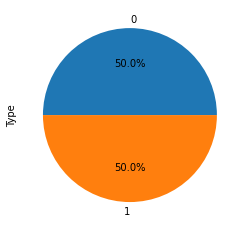

In [ ]:
#get pie of the current imbalance
temp = pd.concat([X_downsampled, y_downsampled], axis=1)
pie_of_imbalance(temp)

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Accuracy train: 0.8719, test:  0.6667
Precision train: 0.8995, test:  0.8084
Recall train: 0.8374, test:  0.6650
F1 train: 0.8762, test:  0.5652


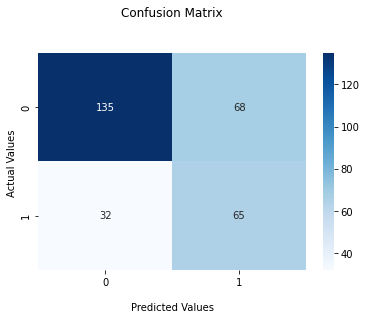

In [ ]:
#Run our function....
model = run_rf_classification_models(X_downsampled, X_test, y_downsampled, y_test)

As we can see, all up and down sampling approaches have outperformed the F1 Score on the imbalanced data. The most impressive performance in this case is from up-sampling using SMOTE synthetic data.

Dealing Imbalances 

Plot the accuracy of our model for all rows in the data set, plotting accuracy for our protected classes: by male and female credits.

Separate the data into train and test

In [ ]:
# Define X and y variables from scratch
cols  = list(df.columns)
cols.remove('class')

# Contains only numerics
X = df[cols]
y = df['class']

# Add binary variable where male=1, female=0
X['gender'] = np.where(df_raw['gender'] == 'female', 1, 0)

#Test and train set    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=None)

Train our classifier using the SMOTE upsampling

In [ ]:
#How many samples do we need to balance?
idx = np.random.choice(X_train.shape[0], size=X_train[y_train == 0].shape[0]-X_train[y_train == 1].shape[0], replace=False)

# Generate SMOTE samples and use this to train
upsampler_smote = SMOTE()
X_upsampled_smote, y_upsampled_smote = upsampler_smote.fit_resample(X_train, y_train)

Train the classifier

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Accuracy train: 0.8648, test:  0.7167
Precision train: 0.8693, test:  0.8191
Recall train: 0.8586, test:  0.7689
F1 train: 0.8656, test:  0.5503


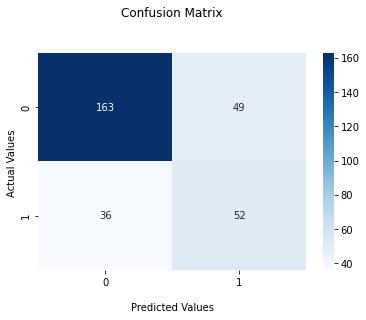

In [ ]:
#Remove the gender column
X_upsampled_smote_exgender = X_upsampled_smote.drop('gender', axis=1)
X_test_exgender = X_test.drop('gender', axis=1)

#Run our function....
model = run_rf_classification_models(X_upsampled_smote_exgender, X_test_exgender, y_upsampled_smote, y_test)

## Finally we check for Protected Characteristics and their Proxies...

We noted at the outset that there was a bias between the protected characterisctis of gender, with male and female credits being different, and we removed this protected characteristic from the dataset to avoid this illegal bias in loan approval outcomes.

Protected characteristics can be picked up (proxied) in other dataitems in more subtle ways though. For instance given that single parent households tend to disproportionately be led by a female adult, this may make 'num_dependents' a proxy for gender.

It is important that we control for any possible protected biases, and one way of achieving this is to retrain our model using a mitigator, which trains by constraining the model weights to produce a balanced outcome between protected classes; male and female credits in this case.

In [ ]:
from sklearn.metrics import accuracy_score

# Run classifier, in sample
y_pred = model.predict(X_test_exgender)

# Analyze metrics using MetricFrame
metric_frame = MetricFrame(metrics=accuracy_score, y_true=y_test, y_pred=y_pred, sensitive_features=X_test['gender'])
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


NameError: ignored

The balance almost equal, this indicates that our model is tending to show now bias based non gender, which indicates that removing the protected dataitem in thefirst place has had a balancing effect on the outcomes. 

However, we can still explicuitly remove correlated features, and constrain model training to remove bias.

### Removing features correlated with protected characteristics

In [ ]:
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from fairlearn.preprocessing import CorrelationRemover
from fairlearn.metrics import MetricFrame

ModuleNotFoundError: ignored

In [ ]:
# List all the columns that are sensitive, supply in a list...
cr = CorrelationRemover(sensitive_feature_ids=['gender'])
cr.fit(X_upsampled_smote)
X_upsampled_smote_cr = cr.transform(X_upsampled_smote)

NameError: ignored

In [ ]:
# We set the balance in the population so we do not under or over-represent males or females...
constraint = DemographicParity(ratio_bound=0.5)

mitigator = ExponentiatedGradient(model, constraint)
mitigator.fit(X_upsampled_smote_cr, y_train, sensitive_features=['gender'])
y_pred_mitigated = mitigator.predict(X_test_exgender)

sr_mitigated = MetricFrame(metrics=accuracy_score, y_true=y_test, y_pred=y_pred_mitigated, sensitive_features=X_upsampled_smote['gender'])
print(sr_mitigated.overall)
print(sr_mitigated.by_group)

NameError: ignored

Let us inspect the results between the "fair" model outcomes and the potentially biased....

In [ ]:

#Print confusion matrix...
cf_matrix = confusion_matrix(y, y_pred_mitigated, labels=[0, 1]) 
cf_matrix_norm = cf_matrix.astype('float') # / cf_matrix.sum(axis=1)[:, np.newaxis]

ax = sns.heatmap(cf_matrix_norm, annot=True, cmap='Reds', fmt='g')
ax.set_title('Confusion Matrix Bias Mitigated\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
plt.show()

print(f"F1 full dataset: {f1_score(y, y_pred_mitigated, average=None)[1]:.4f}")
  
# Analyze metrics using MetricFrame
metric_frame = MetricFrame(metrics=accuracy_score, y_true=y, y_pred=y_pred_mitigated, sensitive_features=df_raw['gender'])
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

NameError: ignored

In [ ]:
#Print confusion matrix... for the unmitigated classifer...
cf_matrix = confusion_matrix(y, y_pred, labels=[0, 1]) 
cf_matrix_norm = cf_matrix.astype('float') # / cf_matrix.sum(axis=1)[:, np.newaxis]

ax = sns.heatmap(cf_matrix_norm, annot=True, cmap='Blues', fmt='g')
ax.set_title('Confusion Matrix Non-Mitigated\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
plt.show()

print(f"F1 full dataset: {f1_score(y, y_pred, average=None)[1]:.4f}")


# Analyze metrics using MetricFrame
metric_frame = MetricFrame(metrics=accuracy_score, y_true=y, y_pred=y_pred, sensitive_features=df_raw['gender'])
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

## Availability heuristic/recency biases? Have we use the correct classifier...?

Using a familiar classifier has its advantages, but differet learners have different inductive biases, and strengths and weaknesses. 
We can create a cross valdation dataset, split from the training data to help us assess different classsifiers...

We need to make a new separation in the training dataset, for a cross-validation
set. This dataset will be used to test the choice of different classifiers after we have used the training data to train them, allowing us to test the classifiers out of sample using the test data.

In [ ]:
#Test and train set    
X_train_cv, X_cv, y_train_cv, y_cv = train_test_split(X_train, y_train, test_size=0.3, random_state=None)

Sklean provides many different classifeirs and we will be testing each accuracy on our problem.

In [ ]:
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

Now build a function that trains a number of different classifiers and the one with the best accuracy on the cross-validation data, we will select as the "best".

X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names


LinearDiscriminantAnalysis()
F1 train: 0.8536, cross-valitaion:  0.4779

Winner
 <class 'sklearn.discriminant_analysis.LinearDiscriminantAnalysis'>
Accuracy train: 0.7794, cross-validation:  0.4381
Precision train: 0.8302, cross-validation:  0.8261
Recall train: 0.9059, cross-validation:  0.2568
F1 train: 0.8536, cross-validation:  0.4779


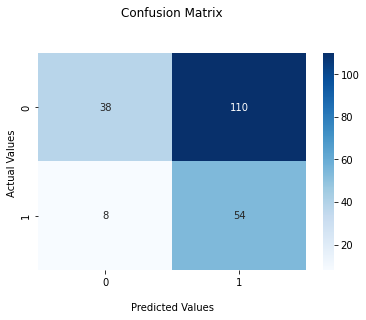

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from imblearn.over_sampling import SMOTE

#Func to wrap up running these selected classification learners...
# NOTE: to test the performance of the learners out-of-sample, we should use a cross-validation dataset
# this is a hold back dataset and we will use our testing data to do this, in this case. 
def auto_classifier_selection(X_train: pd.DataFrame, X_cross_validation: pd.DataFrame, 
                            y_train: pd.DataFrame, y_cross_validation: pd.DataFrame) -> (list, list):
    
    #Balance training data....
    # Generate SMOTE samples and use this to train
    upsampler_smote = SMOTE()
    X_upsampled_smote, y_upsampled_smote = upsampler_smote.fit_resample(X_train, y_train)

    sclr = StandardScaler()
    sclr.fit(X_train) # scale to 0 mean and std dev 1 on training data

    X_train = sclr.fit_transform(X_upsampled_smote) # scale both sets:
    X_cross_validation = sclr.fit_transform(X_cross_validation)
    
    #Run only rf? Or all?
    dtc = DecisionTreeClassifier(max_depth=5) #If we allow endless depth we overfit
    gnb = GaussianNB()
    lr = LogisticRegression(max_iter=2000,random_state=0)
    mlp = MLPClassifier(max_iter=2000,random_state=1, early_stopping=True) # MLP will tend to overfit unless we stop early   
    rf = RandomForestClassifier(max_depth=3,random_state=0)
    lda = LinearDiscriminantAnalysis()
    
    all_mdls = [lda] #[dtc,gnb,lr,mlp,rf, lda]
    
    #Find the best
    max_f1 = 0
    for mdl in all_mdls:
        #Fit model
        mdl.fit(X_upsampled_smote,y_upsampled_smote)
        y_train_hat = mdl.predict(X_upsampled_smote)
        y_cross_validation_hat = mdl.predict(X_cross_validation)       
        mdl.predict_proba(X_cross_validation)

        # Output model selection information....
        print(mdl)
        print(f"F1 train: {f1_score(y_upsampled_smote, y_train_hat, average=None)[1]:.4f}, cross-valitaion: ",
        f"{f1_score(y_cross_validation,y_cross_validation_hat, average=None)[1]:.4f}")
        
        #F1...
        this_f1 = f1_score(y_upsampled_smote,y_train_hat, average=None)[1]
        if this_f1 > max_f1:
            max_f1 = this_f1
            max_mdl = mdl
        
    # The best....
    #Fit...
    max_mdl.fit(X_upsampled_smote,y_upsampled_smote)
    y_train_hat = max_mdl.predict(X_upsampled_smote)
    y_cross_validation_hat = max_mdl.predict(X_cross_validation)
    
    #    Print score
    print('\nWinner\n', type(max_mdl))        
    print(f"Accuracy train: {max_mdl.score(X_train,y_upsampled_smote):.4f}, cross-validation: ",
      f"{max_mdl.score(X_cross_validation,y_cross_validation):.4f}")
    print(f"Precision train: {precision_score(y_upsampled_smote, y_train_hat, average=None)[0]:.4f}, cross-validation: ",
      f"{precision_score(y_cross_validation,y_cross_validation_hat, average=None)[0]:.4f}")
    print(f"Recall train: {recall_score(y_upsampled_smote, y_train_hat, average=None)[0]:.4f}, cross-validation: ",
      f"{recall_score(y_cross_validation,y_cross_validation_hat, average=None)[0]:.4f}")
    print(f"F1 train: {f1_score(y_upsampled_smote, y_train_hat, average=None)[1]:.4f}, cross-validation: ",
      f"{f1_score(y_cross_validation,y_cross_validation_hat, average=None)[1]:.4f}")
        
    #Print confusion matrix...
    cf_matrix = confusion_matrix(y_cross_validation, y_cross_validation_hat, labels=[0, 1]) 
    cf_matrix_norm = cf_matrix.astype('float')

    ax = sns.heatmap(cf_matrix_norm, annot=True, cmap='Blues', fmt='g')
    ax.set_title('Confusion Matrix\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');
    plt.show()
    
    return max_mdl, all_mdls

# Run our function....autoselect the best classifier wrt F1
max_mdl, all_models = auto_classifier_selection(X_train_cv, X_cv, y_train_cv, y_cv)

# Predict
y_test_hat = max_mdl.predict(X_test)

# Stage4: Model Deployment 

Model deployment generally involves a change process, several levels of testing and sign off, asignment of responsibilities for the live operation of the process, models and data before deployiong the code to the cloud (or on native hardware). 
A key part of thius stage is communication of the KPIs to stakleholders to enable them to understand the way the models operate, the risks involved and to be accountable for deploying the models


## Communication: Stakeholder Oriented Explanations

Communication of how the model has reached the outcomes it is has, is crutial to achieve fairness, transparency, accountability, and trust in the whole process. Each stakeholder in the process needs to see different elements. The Data Scientist and technical leadership need to review the nut and bolts of the model, reviewing residuals plots, parameter importance, interaction terms and many other metrics. The customer needs to see far less information, and mainly that associated with a refusal of credit. Compliance resources and regulators need to see something different again, such as fairness regarding protected characteristics, the accuracy and therefore capital risk represented by the models. 
In this section we look at stakeholder oriented explanations and we will be using standard charts of important analytics, such as residual plots, and SHAP.

First let us get the packages we will need...

In [ ]:
pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 5.1 MB/s 


In [ ]:
import shap

Now instantiate the SHAP explainer object for our classifier and generate Shapley values for the test data... Note that as we will be using the test data, all the analysis is therefore based on the out of sample performance of our model.

In [ ]:
print(type(max_mdl).__name__)

# Instantiate an explainer object for our chosen classifier...
if type(max_mdl).__name__ == 'DecisionTreeClassifier':
  explainer = shap.Explainer(max_mdl)
elif type(max_mdl).__name__ == 'GaussianNB':
  masker=shap.maskers.Impute(data=X_test) #,feature_names=X_test.columns)
elif type(max_mdl).__name__ == 'LogisticRegression':
  masker=shap.maskers.Impute(data=X_test) #,feature_names=X_test.columns)
elif type(max_mdl).__name__ == 'MLPClassifier':
  masker=shap.maskers.Impute(data=X_test) #,feature_names=X_test.columns)
elif type(max_mdl).__name__ == 'RandomForestClassifier':
  explainer = shap.Explainer(max_mdl)
elif type(max_mdl).__name__ == 'LinearDiscriminantAnalysis':
  masker = shap.maskers.Independent(data = X_test)
  explainer = shap.LinearExplainer(max_mdl, masker = masker)

# Get the Shapley values for the X_test data...
shap_values = explainer(X_test)

LinearDiscriminantAnalysis


## 1. Analyst and technical explainability

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.


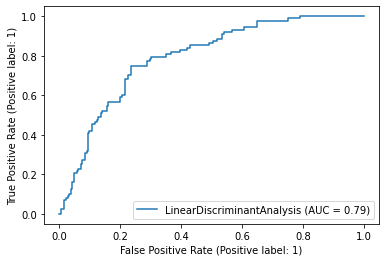

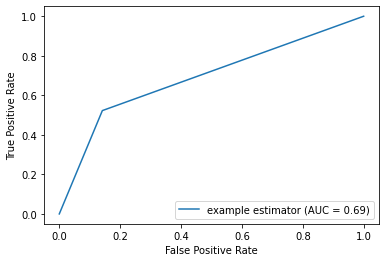

In [ ]:
import sklearn.metrics as metrics

# Compute micro-average ROC curve and ROC area
metrics.plot_roc_curve(max_mdl, X_test, y_test) 

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_hat)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='example estimator')
display.plot()

plt.show()

Feature importance

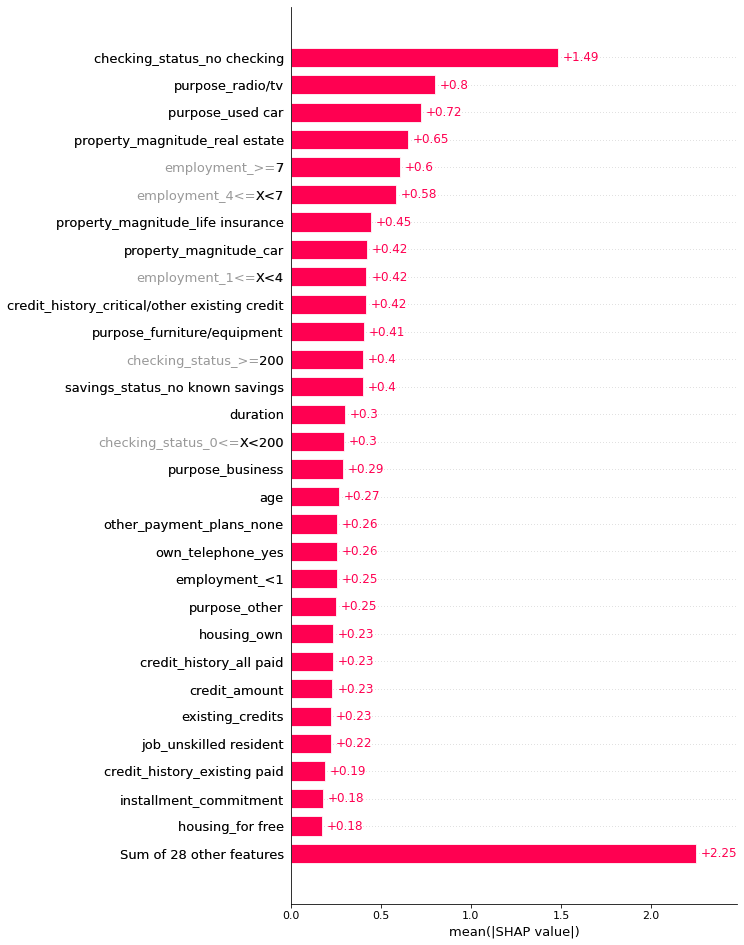

In [ ]:
# Plot the feature importance
shap.plots.bar(shap_values, max_display=30)

## 2. Compliance and Regulatory



See if any features are suspiciously important for one gender vs another.

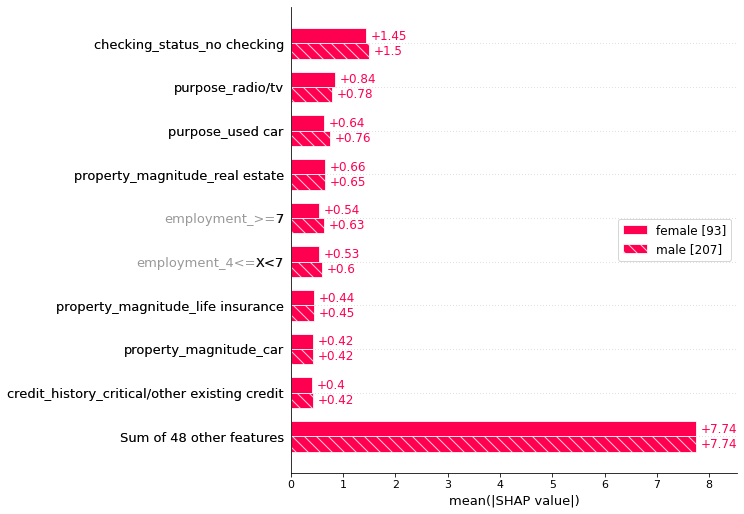

In [ ]:
# Parameter importance by gender..
gdr = ["male" if x==1 else "female" for x in X_test['gender']]

# Plot the feature importance
shap.plots.bar(shap_values.cohorts(gdr).abs.mean(0))

## 3. Customer

A customer may want to knowlt he sensitivity of the decision to certain characteristics. IF a refusal has been made, it would be beneficial to report to the customer what they need to change to get a favorable outcome. 

We can use the SHAP waterfall plot to help

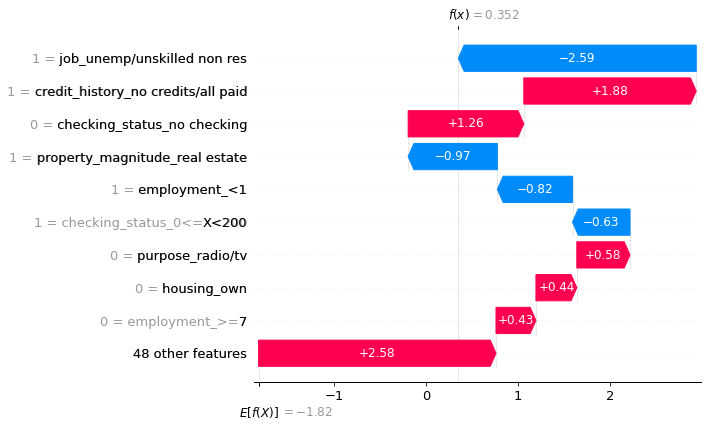

In [ ]:
# Find a customer with bad credit prediction
for rejected_eg_rowno in range(0,y_test.shape[0]):
  if y_test.iloc[rejected_eg_rowno] == 1:
    break

# This customer was refused credit and we can provide an explanation for their refusal...
shap.plots.waterfall(shap_values[rejected_eg_rowno])

In [ ]:
y_test.reset_index()

,index,class
0,255,0
1,485,1
2,182,1
3,128,0
4,916,0
...,...,...
295,892,0
296,4,1
297,729,0
298,903,0
